# **수익형 블로그를 위한 키워드 분석**



---
코랩에서 selenium을 사용하기 위해 chromedriver 설치

In [29]:
import sys

!sudo add-apt-repository ppa:saiarcot895/chromium-beta
!sudo apt remove chromium-browser
!sudo snap remove chromium-browser

!pip3 install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

sys.path.insert(0, '/usr/lib/chromium-browser/chromedirver')

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/saiarcot895/chromium-beta/ubuntu/ jammy main'
Description:
This PPA contains the latest Chromium Beta builds, with hardware video decoding enabled (hidden behind a flag), and support for Widevine (needed for viewing many DRM-protected videos) enabled.

== Hardware Video Decoding ==

To enable hardware video decoding, start Chromium with the --enable-features=VaapiVideoDecoder argument. To make this persistent, create a file at /etc/chromium-browser/customizations/92-vaapi-hardware-decoding with the following contents:

CHROMIUM_FLAGS="${CHROMIUM_FLAGS} --enable-features=VaapiVideoDecoder"

See also https://wiki.archlinux.org/title/Chromium#Hardware_video_acceleration for more information on VAAPI video decoding support.

=== Widevine Support ===

The packages in this PPA have support for Widevine inside Chromium enabled. However, you still need to copy some files from 

---
matplotlib 에서 한글을 사용하기위해 한글폰트 설정

In [30]:
# 한글폰트
font_path = "./NanumGothic.ttf"
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.sans-serif'] = font_manager.FontProperties(fname=font_path).get_name()

---

API 호출을 위한 다양한 파이썬 라이브러리와 모듈을 임포트하는 부분입니다.

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import hmac
import base64
from datetime import datetime, timedelta
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image
import urllib.request
import time
import hashlib
from matplotlib import font_manager
from sklearn.linear_model import LinearRegression
from api_credentials import API_KEY, SECRET_KEY, CUSTOMER_ID, CLIENT_ID, CLIENT_SECRET
import xml.etree.ElementTree as ET

In [32]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys

---

네이버 광고 API 호출을 위한 서명 생성과 HTTP 요청 헤더 설정을 위한 클래스와 함수를 정의합니다. Signature 클래스는 서명을 생성하고, get_header 함수는 API 요청에 필요한 HTTP 헤더를 구성합니다.

In [33]:
class Signature:
    @staticmethod
    def generate(timestamp, method, uri, secret_key):
        message = "{}.{}.{}".format(timestamp, method, uri)
        hash = hmac.new(bytes(secret_key, "utf-8"), bytes(message, "utf-8"), hashlib.sha256)
        return base64.b64encode(hash.digest())

# API 헤더 생성 함수
def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = Signature.generate(timestamp, method, uri, secret_key)
    return {'Content-Type': 'application/json; charset=UTF-8', 'X-Timestamp': timestamp,
            'X-API-KEY': api_key, 'X-Customer': str(customer_id), 'X-Signature': signature}

---

이 함수는 Naver 검색 API를 사용해 주어진 키워드에 대한 전체 문서 수를 가져옵니다. API 요청에 필요한 인증 정보를 포함하고, 성공적인 응답 시 전체 문서 수를 반환합니다.

In [34]:
# 키워드에 대한 전체 문서 수를 가져오는 함수
def get_total_documents(keyword):
    encText = urllib.parse.quote(keyword)
    url = "https://openapi.naver.com/v1/search/webkr.json?query=" + encText
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", CLIENT_ID)
    request.add_header("X-Naver-Client-Secret", CLIENT_SECRET)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    try:
        if rescode == 200:
            response_body = response.read()
            text = response_body.decode('utf-8')
            total_docs = json.loads(text)['total']
            return total_docs
        else:
            print("Error Code:", rescode)
            return 0
    except Exception as e:
        print("Error:", str(e))
        return 0

 ---

 이 함수는 네이버 검색 API를 이용하여 특정 키워드의 월별 검색 비율을 가져오는 기능을 합니다. 지정된 기간 동안의 검색 트렌드 데이터를 요청하고, 성공적인 응답을 받으면 그 데이터를 반환합니다. 오류가 발생하면 오류 코드를 출력합니다.

In [35]:
# 키워드의 월별 검색 비율을 가져오는 함수
def get_month_ratios(keyword):
    url = "https://openapi.naver.com/v1/datalab/search"

    startDate = "2016-01-01"  # 시작일 설정
    endDate = "2023-11-01"    # 종료일 설정
    timeUnit = "date"         # 시간 단위 설정

    keywordGroups = []

    keywords = []
    keywords.append(keyword)

    keywordGroups.append({"groupName": keyword, "keywords": keywords})

    body = {
        "startDate": startDate,
        "endDate": endDate,
        "timeUnit": timeUnit,
        "keywordGroups": keywordGroups
    }

    body = json.dumps(body, ensure_ascii=False)

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", CLIENT_ID)
    request.add_header("X-Naver-Client-Secret", CLIENT_SECRET)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()

    if (rescode == 200):
        response_body = response.read()
        return response_body.decode('utf-8')
    else:
        print("Error Code:" + rescode)
        return 0

---

이 함수는 Naver의 검색 광고 API를 사용해 주어진 키워드에 대한 관련 정보를 조회하고 결과를 데이터프레임으로 반환합니다. 특정 키워드에 대한 세부 정보를 포함한 결과를 받아옵니다.

In [36]:
# 키워드에 대한 결과를 가져오는 함수
def get_results(hintKeywords):
    BASE_URL = 'https://api.searchad.naver.com'
    uri = '/keywordstool'
    method = 'GET'

    params = {}

    params['hintKeywords'] = hintKeywords
    params['showDetail'] = '1'

    r = requests.get(BASE_URL + uri, params=params,
                     headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

    return pd.DataFrame(r.json()['keywordList'])

---

이 함수는 Google Suggest API를 이용하여 주어진 검색 쿼리에 대한 추천 검색어 목록을 가져오는 기능을 수행합니다. API로부터 받은 XML 응답을 파싱하여 각 추천 검색어를 리스트에 저장한 후 반환합니다.

In [37]:
def get_google_suggestions(search_query):
    # Google Suggest API URL 설정
    url = f"https://suggestqueries.google.com/complete/search?output=toolbar&q={search_query}"

    # 요청 보내고 응답 받기
    response = requests.get(url)

    # 응답을 파싱하기 위해 XML 파서 사용
    xml_data = response.text
    root = ET.fromstring(xml_data)

    # 추천 검색어를 저장할 리스트 초기화
    suggestions = []

    # 각 CompleteSuggestion 요소를 반복하여 추천 검색어 데이터 추출
    for suggestion in root.findall(".//CompleteSuggestion"):
        data = suggestion.find("suggestion").attrib["data"]
        suggestions.append(data)

    return suggestions

---

이 함수는 Google 검색 결과에서 특정 키워드에 대한 웹페이지 링크를 스크랩하는 기능을 합니다. 주요 단계는 다음과 같습니다:

Chrome 드라이버 초기화: Selenium 라이브러리를 사용하여 Chrome 웹 드라이버를 초기화합니다. headless 모드로 실행하여 브라우저 UI 없이 백그라운드에서 작업을 진행합니다.

Google 검색 실행: 검색창을 찾아 검색어를 입력하고 검색을 실행합니다.

스크롤 및 링크 수집: 페이지 끝까지 스크롤하며 검색 결과 링크들을 수집합니다. 설정된 최대 길이(max_len)에 도달하거나 더 이상의 결과가 없으면 수집을 중단합니다.

블로그 및 사이트 카운팅: 수집된 링크들 중 특정 블로그 도메인을 포함하는 링크들을 카운팅하고 별도의 리스트에 저장합니다.

결과 반환: 수집된 블로그 링크 수, 전체 링크 수, 블로그 링크 리스트를 반환합니다

In [38]:
def scrape_google_results(search_query, max_len=14):
    # Chrome 옵션 및 서비스 초기화
    service = Service(executable_path=r'/usr/bin/chromedriver')
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(service=service, options=options)

    # 결과를 저장할 리스트 초기화
    collected_links = []

    try:
        # Google 웹사이트 열기
        driver.get("http://www.google.com")

        # 검색창 찾기
        search_box = driver.find_element(By.NAME, 'q')

        # 검색어 입력 및 검색 실행
        search_box.send_keys(search_query)
        search_box.send_keys(Keys.RETURN)

        # 스크롤 및 결과 처리 루프
        while len(collected_links) < max_len:
            # 페이지의 마지막까지 스크롤
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(4)  # 추가 결과 로드를 기다리는 시간

            # 현재 페이지의 모든 결과 가져오기
            results = driver.find_elements(By.CSS_SELECTOR, 'div.g')

            # 결과 처리
            for result in results:
                if len(collected_links) >= max_len:
                    break  # max_len 되면 루프 탈출
                link = result.find_element(By.CSS_SELECTOR, 'a').get_attribute('href')
                if link not in collected_links:
                    collected_links.append(link)

            if len(collected_links) >= max_len:
                break  # max_len 되면 바깥 루프도 탈출
    finally:
        # 브라우저 종료
        driver.quit()
    print("크롤링 완료 블로그 카운팅 시작")
    blog_count = 0
    site_count = 0
    blog_links = []
    for link in collected_links:
        # 특정 도메인 포함 여부 확인
        if 'tistory.com' in link or 'brunch.co.kr' in link or 'blog.naver.com' in link or 'velog.io' in link or 'medium.com' in link:
            blog_count += 1
            blog_links.append(link)
        site_count += 1

    return blog_count, site_count, blog_links


---

데이터 저장을 위한 리스트 초기화:
total_documents: 키워드별 전체 문서 수를 저장할 리스트입니다.

blog_links: 각 키워드에 대한 블로그 링크를 저장할 리스트입니다.

month_ratios: 키워드의 월별 검색 비율을 저장할 리스트입니다.

suggest_keywords: Google 추천 검색어를 저장할 리스트입니다.

link_count: 수집된 링크의 수를 저장할 리스트입니다.

cell_data: 추가 데이터 저장을 위한 리스트입니다.


키워드 입력 받기:
hintKeywords: 사용자에게 큰 주제의 검색어를 입력받습니다. 예시로 "파이썬, 개발"과 같은 키워드가 제시됩니다.


결과 데이터프레임 생성:
get_results 함수를 호출하여 입력받은 힌트 키워드에 대한 검색 결과를 가져옵니다.
결과는 판다스(Pandas)의 데이터프레임(resultdf) 형태로 저장됩니다.


In [39]:
total_documents = []
blog_links = []
month_ratios = []
suggest_keywords = []
link_count = []
cell_data =[]

hintKeywords = input("큰 주제의 검색어를 입력하세요 ex)파이썬, 개발 : ")
resultdf = get_results(hintKeywords)

큰 주제의 검색어를 입력하세요 ex)파이썬, 개발 : 파이썬


---

데이터프레임의 열 이름을 변경하고, 문자열로 된 데이터를 숫자형으로 변환하는 과정을 수행합니다.

In [40]:
# 열 이름 변경
new_column_names = {
    'relKeyword': 'Keyword',
    'monthlyPcQcCnt': '월간검색수(PC)',
    'monthlyMobileQcCnt': '월간검색수(모바일)',
    'monthlyAvePcClkCnt': '광고클릭수(PC)',
    'monthlyAveMobileClkCnt': '광고클릭수(모바일)',
    'monthlyAvePcCtr': '광고클릭률(PC)',
    'monthlyAveMobileCtr': '광고클릭률(모바일)',
    'plAvgDepth': '노출광고수',
    'compIdx': '경쟁정도'
}

# 문자열 형태의 열을 숫자로 변환
resultdf['monthlyPcQcCnt'] = pd.to_numeric(resultdf['monthlyPcQcCnt'], errors='coerce')
resultdf['monthlyMobileQcCnt'] = pd.to_numeric(resultdf['monthlyMobileQcCnt'], errors='coerce')

---

데이터프레임에서 주어진 키워드를 포함하고 월간 검색수가 200건 이상인 데이터만 필터링하고, 이를 'origin.xlsx' 파일로 저장합니다.

In [41]:
# 키워드가 포함되어있는 키워드만 필터링
resultdf = resultdf[resultdf['relKeyword'].str.contains(hintKeywords)]

# 월간검색수가 200건 이상인 행만 유지
resultdf = resultdf[(resultdf['monthlyPcQcCnt'] + resultdf['monthlyMobileQcCnt']).fillna(0) >= 200]
resultdf = resultdf.rename(columns=new_column_names)
resultdf.to_excel('origin.xlsx', index=False)


---

데이터프레임에 있는 각 키워드에 대해 문서 수를 카운팅하고, Google에서 추천하는 연관 검색어를 파싱하는 작업을 수행합니다. 각 키워드에 대해 get_total_documents와 get_google_suggestions 함수를 호출하여 총 문서 수와 연관 검색어 목록을 가져온 후, 이들을 각각 total_documents와 suggest_keywords 리스트에 추가합니다.

In [42]:
print("문서수 카운팅 및 연관검색어 파싱 시작")
for i, keyword in enumerate(resultdf['Keyword'], start=1):
    print(f"{i}/{len(resultdf)}: '{keyword}' 문서수 카운팅 및 연관검색어 파싱중")
    total_docs = get_total_documents(keyword)
    total_documents.append(total_docs)
    suggest_keyword = get_google_suggestions(keyword)
    suggest_keywords.append(suggest_keyword)

문서수 카운팅 및 연관검색어 파싱 시작
1/37: '파이썬' 문서수 카운팅 및 연관검색어 파싱중
2/37: '파이썬인강' 문서수 카운팅 및 연관검색어 파싱중
3/37: '파이썬독학' 문서수 카운팅 및 연관검색어 파싱중
4/37: '파이썬강의' 문서수 카운팅 및 연관검색어 파싱중
5/37: '파이썬자격증' 문서수 카운팅 및 연관검색어 파싱중
6/37: '파이썬프로그램' 문서수 카운팅 및 연관검색어 파싱중
7/37: '파이썬교육' 문서수 카운팅 및 연관검색어 파싱중
8/37: '파이썬기초' 문서수 카운팅 및 연관검색어 파싱중
9/37: '파이썬마스터' 문서수 카운팅 및 연관검색어 파싱중
10/37: '파이썬설치' 문서수 카운팅 및 연관검색어 파싱중
11/37: '파이썬데이터분석' 문서수 카운팅 및 연관검색어 파싱중
12/37: '온라인파이썬' 문서수 카운팅 및 연관검색어 파싱중
13/37: '파이썬다운로드' 문서수 카운팅 및 연관검색어 파싱중
14/37: '파이썬코딩' 문서수 카운팅 및 연관검색어 파싱중
15/37: '파이썬공부' 문서수 카운팅 및 연관검색어 파싱중
16/37: '파이썬활용' 문서수 카운팅 및 연관검색어 파싱중
17/37: '파이썬장고' 문서수 카운팅 및 연관검색어 파싱중
18/37: '파이썬알고리즘' 문서수 카운팅 및 연관검색어 파싱중
19/37: '파이썬언어' 문서수 카운팅 및 연관검색어 파싱중
20/37: '파이썬프로그래밍' 문서수 카운팅 및 연관검색어 파싱중
21/37: '파이썬엑셀' 문서수 카운팅 및 연관검색어 파싱중
22/37: '파이썬웹크롤링' 문서수 카운팅 및 연관검색어 파싱중
23/37: '파이썬크롤링' 문서수 카운팅 및 연관검색어 파싱중
24/37: '파이썬예제' 문서수 카운팅 및 연관검색어 파싱중
25/37: '파이썬자바' 문서수 카운팅 및 연관검색어 파싱중
26/37: '파이썬클래스' 문서수 카운팅 및 연관검색어 파싱중
27/37: '파이썬머신러닝' 문서수 카운팅 및 연관검색어 파싱중
28/37: '파이썬프로젝트' 문서수 카운

---

데이터프레임에 새로운 지표를 추가하고, 경쟁-검색 균형 지수가 높은 상위 3개 키워드를 선별합니다.

In [43]:
resultdf['광고클릭률'] = resultdf['광고클릭률(모바일)'] + resultdf['광고클릭률(PC)']
resultdf['연관검색어'] = suggest_keywords
resultdf['총문서수'] = total_documents
resultdf['총검색량'] = (resultdf['월간검색수(PC)'] + resultdf['월간검색수(모바일)'])
resultdf['경쟁정도_ratio'] = resultdf['총문서수'] / (resultdf['월간검색수(PC)'] + resultdf['월간검색수(모바일)'])

# 경쟁-검색 균형 지수 계산
resultdf['경쟁-검색 균형 지수'] = (resultdf['월간검색수(PC)'] + resultdf['월간검색수(모바일)']) / (resultdf['경쟁정도_ratio'] + 1)


# 코랩에서 크롤링이 느려 3개 데이터만 받아올 수 있게 경쟁 균형지수로 내림차순 정렬하여 상위 3개로 줄입니다.
resultdf = resultdf.sort_values(by='경쟁-검색 균형 지수', ascending=False)
resultdf = resultdf.head(3);


---

주어진 키워드 중에서 경쟁-검색 균형 지수가 가장 높은 상위 3개의 키워드에 대해 월간 검색 비율과 구글 상위 블로그 정보를 크롤링으로 수집하여 결과 데이터프레임에 저장하는 작업을 수행합니다.

In [50]:

# 코랩에서 크롤링이 느려 3개 데이터만 받아올 수 있게 경쟁 균형지수로 내림차순 정렬하여 상위 3개로 줄입니다.
resultdf = resultdf.sort_values(by='경쟁-검색 균형 지수', ascending=False)
resultdf = resultdf.head(3);

print("월별 검색 ratio 및 블로그글 크롤링 시작")
for i, keyword in enumerate(resultdf['Keyword'], start=1):
    print(f"{i}/{len(resultdf)}: '{keyword}' 크롤링 중...")
    month_ratio = get_month_ratios(keyword)
    month_ratios.append(month_ratio)
    blog_count, site_count, blog_link = scrape_google_results(keyword)
    blog_links.append(blog_link)
    link_count.append(blog_count)

resultdf['구글 상위 블로그 상위 갯수'] = link_count
resultdf['구글 상위 블로그'] = blog_links
resultdf['월간 ratio'] = month_ratios

월별 검색 ratio 및 블로그글 크롤링 시작
1/3: '파이썬' 크롤링 중...


KeyboardInterrupt: ignored

---

DataFrame인 resultdf에서 여러 열을 삭제하는 작업을 수행합니다.

각 줄은 특정 열을 삭제하는 명령을 포함하고 있습니다.

열을 삭제할 때 drop 메서드를 사용하며, 삭제하려는 열의 이름과 축(axis)을 지정합니다.

In [45]:
resultdf = resultdf.drop('월간검색수(PC)', axis=1)
resultdf = resultdf.drop('월간검색수(모바일)', axis=1)
resultdf = resultdf.drop('경쟁정도', axis=1)
resultdf = resultdf.drop('광고클릭수(모바일)', axis=1)
resultdf = resultdf.drop('광고클릭수(PC)', axis=1)
resultdf = resultdf.drop('광고클릭률(모바일)', axis=1)
resultdf = resultdf.drop('광고클릭률(PC)', axis=1)


위 코드는 resultdf DataFrame의 각 행에서 10번째 열(2016~2023 일별 관심도)의 데이터를 JSON 형식으로 파싱하여 cell_data 리스트에 추가하는 작업을 수행합니다.

In [46]:
for index in range(resultdf.shape[0]):
    cell_data.append(json.loads(resultdf.iloc[index, 10]))
    print(cell_data)

[{'startDate': '2016-01-01', 'endDate': '2023-11-01', 'timeUnit': 'date', 'results': [{'title': '파이썬', 'keywords': ['파이썬'], 'data': [{'period': '2016-01-01', 'ratio': 6.21457}, {'period': '2016-01-02', 'ratio': 6.72064}, {'period': '2016-01-03', 'ratio': 9.12955}, {'period': '2016-01-04', 'ratio': 12.61133}, {'period': '2016-01-05', 'ratio': 12.48987}, {'period': '2016-01-06', 'ratio': 11.21457}, {'period': '2016-01-07', 'ratio': 11.25506}, {'period': '2016-01-08', 'ratio': 9.12955}, {'period': '2016-01-09', 'ratio': 6.82186}, {'period': '2016-01-10', 'ratio': 7.38866}, {'period': '2016-01-11', 'ratio': 11.35627}, {'period': '2016-01-12', 'ratio': 11.92307}, {'period': '2016-01-13', 'ratio': 9.83805}, {'period': '2016-01-14', 'ratio': 8.62348}, {'period': '2016-01-15', 'ratio': 8.44129}, {'period': '2016-01-16', 'ratio': 5.50607}, {'period': '2016-01-17', 'ratio': 8.92712}, {'period': '2016-01-18', 'ratio': 13.62348}, {'period': '2016-01-19', 'ratio': 13.17813}, {'period': '2016-01-20'

---
 JSON 데이터를 활용하여 검색 관심도의 시계열 데이터를 분석하고 시각화합니다.

 각 데이터에 대해 선형 회귀 모델을 훈련하여 미래 1년 동안의 추이를 예측하고, 각 연도별로 계절별 배경 색상을 설정하여 결과를 시각적으로 표시하고 이미지 파일로 저장합니다.

2016년 ~ 2023년 데이터 준비
선형 회귀 모델 훈련 중
시계열분석 데이터 예측 중


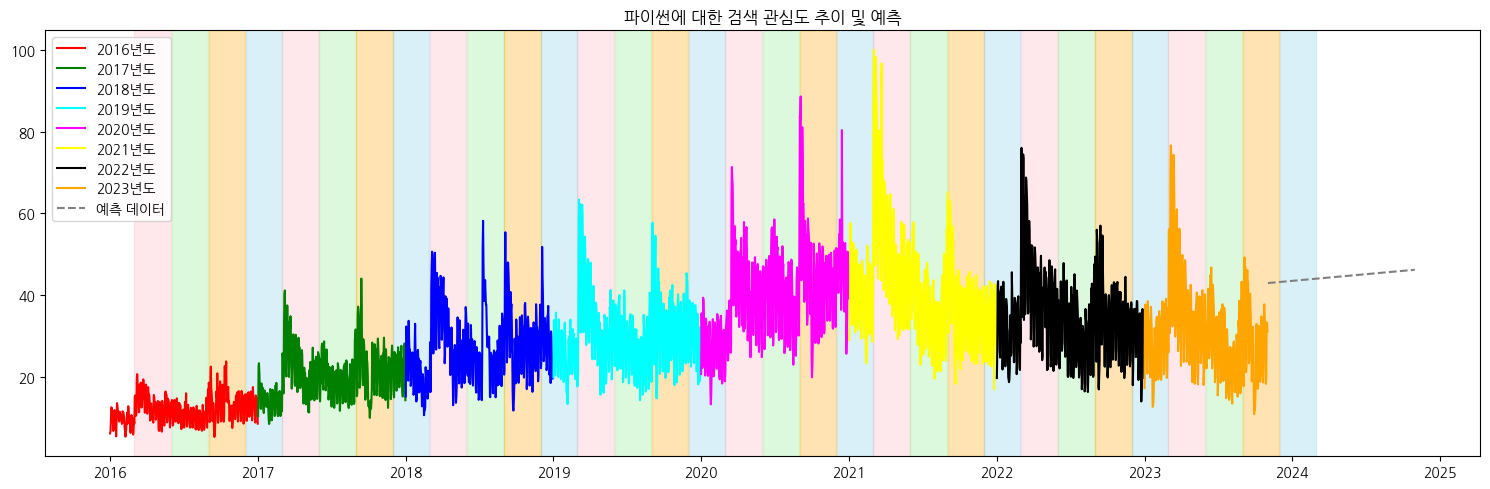

2016년 ~ 2023년 데이터 준비
선형 회귀 모델 훈련 중
시계열분석 데이터 예측 중


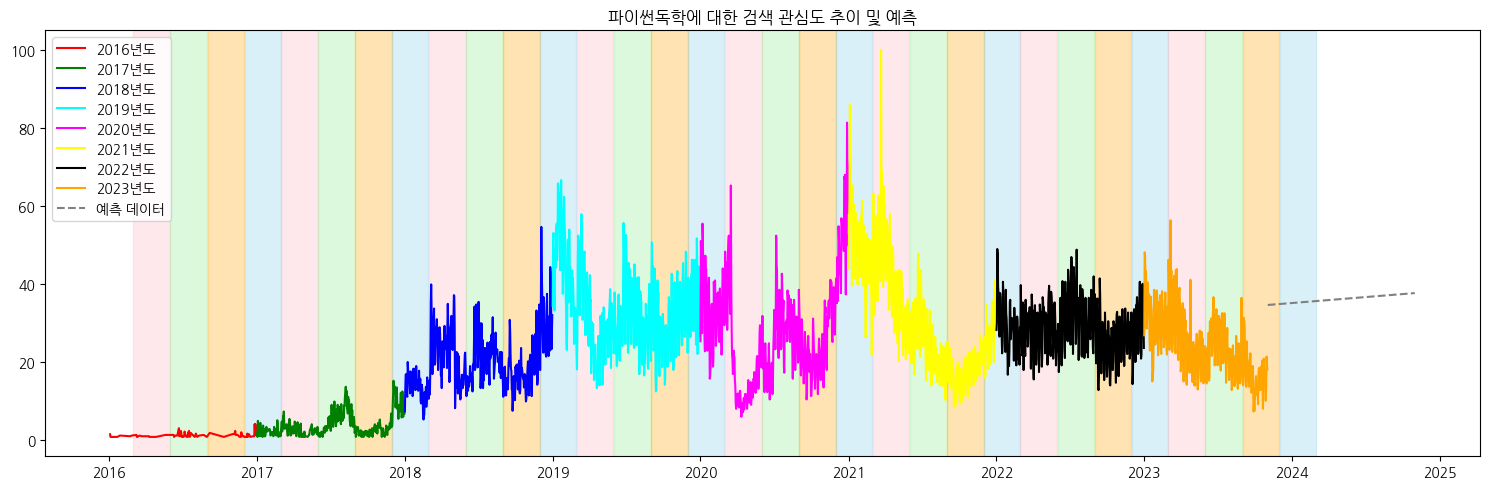

2016년 ~ 2023년 데이터 준비
선형 회귀 모델 훈련 중
시계열분석 데이터 예측 중


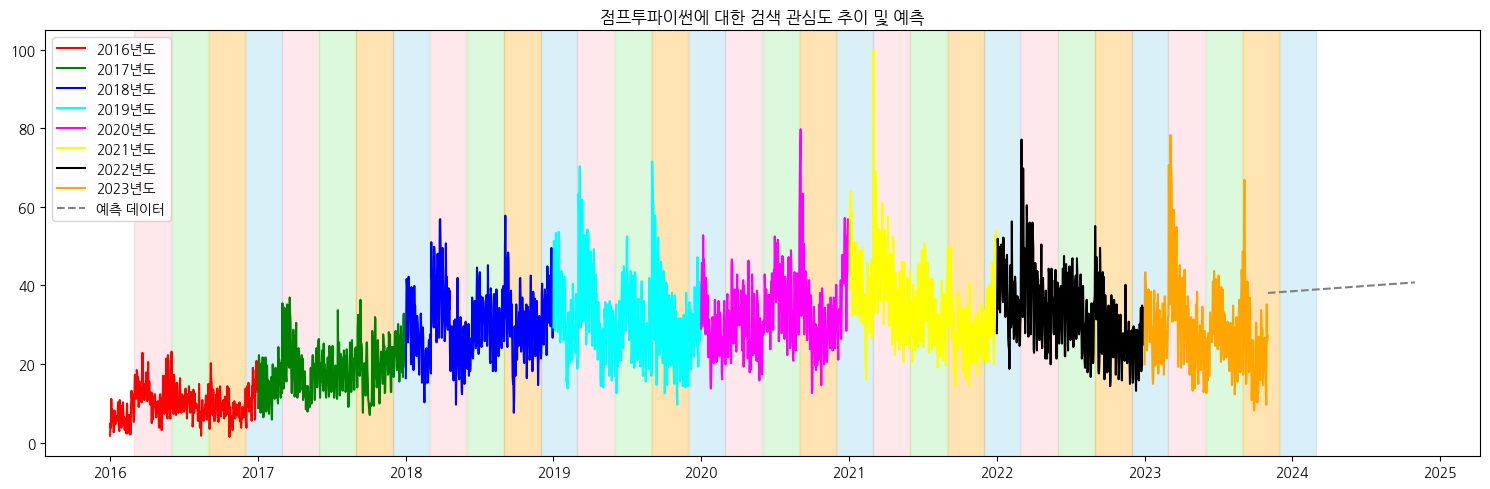

In [47]:
for index, item in enumerate(cell_data):
    results_data = item['results'][0]['data']
    title = item['results'][0]['title']

    # 데이터 준비
    print("2016년 ~ 2023년 데이터 준비")
    periods = [d['period'] for d in item['results'][0]['data']]
    ratios = [d['ratio'] for d in item['results'][0]['data']]
    dates = [datetime.strptime(period, "%Y-%m-%d") for period in periods]
    df = pd.DataFrame({'Date': dates, 'Ratio': ratios})

    # 선형 회귀 모델 훈련
    print("선형 회귀 모델 훈련 중")
    df['DateInt'] = df['Date'].apply(lambda x: x.toordinal())
    model = LinearRegression()
    model.fit(df[['DateInt']], df['Ratio'])

    # 미래 3개월 예측
    print("시계열분석 데이터 예측 중")
    last_date = df['Date'].iloc[-1]
    future_dates = [last_date + timedelta(days=x) for x in range(1, 365)]
    future_date_int = [d.toordinal() for d in future_dates]
    future_df = pd.DataFrame({'DateInt': future_date_int})
    future_predictions = model.predict(future_df)

    # 시각화
    fig, ax = plt.subplots(figsize=(15, 5))
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'orange']
    years = df['Date'].dt.year.unique()
    for i, year in enumerate(years):
        year_data = df[df['Date'].dt.year == year]
        ax.plot(year_data['Date'], year_data['Ratio'], label=f'{year}년도', color=colors[i % len(colors)])

    # 예측 데이터
    ax.plot(future_dates, future_predictions, label='예측 데이터', linestyle='--', color='gray')

    # 계절별 배경 색상 설정
    for year in range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1):
        # 봄: 3월 1일부터 5월 31일 핑크
        ax.axvspan(datetime(year, 3, 1), datetime(year, 5, 31), color='lightpink', alpha=0.3)
        # 여름: 6월 1일부터 8월 31일 초록
        ax.axvspan(datetime(year, 6, 1), datetime(year, 8, 31), color='lightgreen', alpha=0.3)
        # 가을: 9월 1일부터 11월 30일 주황
        ax.axvspan(datetime(year, 9, 1), datetime(year, 11, 30), color='orange', alpha=0.3)
        # 겨울: 12월 1일부터 다음 해 2월 28일(윤년 체크 필요) 파랑
        end_day = 29 if (year + 1) % 4 == 0 and ((year + 1) % 100 != 0 or (year + 1) % 400 == 0) else 28
        ax.axvspan(datetime(year, 12, 1), datetime(year + 1, 2, end_day), color='skyblue', alpha=0.3)

    ax.set_title(title+'에 대한 검색 관심도 추이 및 예측')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{index}.png')
    plt.show()




---
DataFrame인 resultdf의 열 데이터를 가공하여 Excel 파일로 저장하는 작업을 수행합니다.

'연관검색어' 및 '구글 상위 블로그' 열의 리스트 형식 데이터를 개행 문자로 구분된 문자열로 변환합니다.

필요없는 열 '구글 상위 블로그 상위 갯수' 열을 삭제한 후, 수정된 DataFrame을 'output.xlsx'라는 Excel 파일로 저장합니다.

In [48]:
resultdf['연관검색어'] = resultdf['연관검색어'].apply(lambda x: '\n'.join(x) if isinstance(x, list) else x)
resultdf['구글 상위 블로그'] = resultdf['구글 상위 블로그'].apply(lambda x: '\n'.join(x) if isinstance(x, list) else x)
resultdf = resultdf.drop('구글 상위 블로그 상위 갯수', axis=1)

resultdf.to_excel('output.xlsx', index=False)



---
Python에서 openpyxl 라이브러리를 사용하여 이미지를 삽입한 엑셀 파일을 생성하고 저장하는 작업을 수행합니다. 코드는 엑셀 파일을 열고, 워크시트에서 이미지를 원하는 위치에 삽입하며, 열과 행의 크기를 조정한 후 새로운 이름으로 엑셀 파일을 저장합니다.







In [49]:
# 엑셀 워크북 생성
wb = load_workbook(filename='output.xlsx')

# 워크북의 첫 번째 워크시트 가져오기
ws = wb.active

# 두 번째 행부터 시작하여 마지막 행까지 반복
for index in range(1, ws.max_row):
    img_path = f"{index-1}.png"

    # 이미지 객체 생성 및 리스트에 추가
    img = Image(img_path)
    # 이미지를 원하는 셀 위치에 삽입
    ws.add_image(img, f"J{index + 1}")
    ws.row_dimensions[index + 1].height = 380

# 엑셀 셀 크기 조정
ws.column_dimensions['A'].width = 26
ws.column_dimensions['B'].width = 12
ws.column_dimensions['C'].width = 11
ws.column_dimensions['D'].width = 25
ws.column_dimensions['E'].width = 13
ws.column_dimensions['F'].width = 13
ws.column_dimensions['G'].width = 13
ws.column_dimensions['H'].width = 13
ws.column_dimensions['I'].width = 50
ws.column_dimensions['J'].width = 190
# 엑셀 파일 저장

wb.save('result.xlsx')